In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [5]:
# Wine Quality Prediction - Cleand & Documented Notebook

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Read data
train_data = pd.read_csv("/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")
df = train_data.copy()

# *1.Basic EDA*

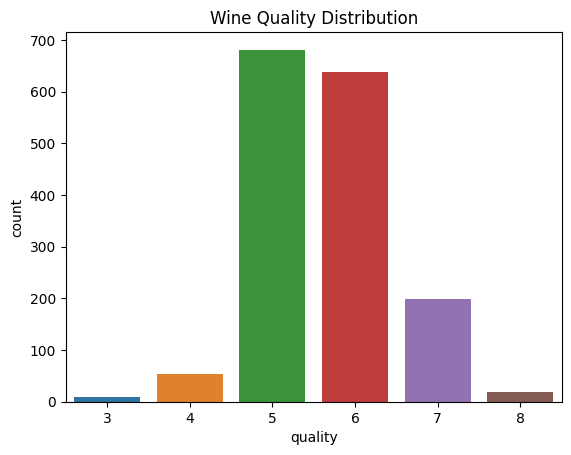

In [6]:
sns.countplot (x= 'quality', data=df)
plt.title('Wine Quality Distribution')
plt.show()

In [7]:
# Summary statistics

print(df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

In [8]:
# Null value check
print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [9]:
# Standard deviation
print(df.std().sort_values(ascending=False))

total sulfur dioxide    32.895324
free sulfur dioxide     10.460157
fixed acidity            1.741096
residual sugar           1.409928
alcohol                  1.065668
quality                  0.807569
citric acid              0.194801
volatile acidity         0.179060
sulphates                0.169507
pH                       0.154386
chlorides                0.047065
density                  0.001887
dtype: float64


In [10]:
# Coefficient of variation

cv = df.std() /df.mean()
print(cv.sort_values(ascending=False))

citric acid             0.718888
total sulfur dioxide    0.707917
free sulfur dioxide     0.658911
residual sugar          0.555351
chlorides               0.538095
volatile acidity        0.339244
sulphates               0.257551
fixed acidity           0.209276
quality                 0.143287
alcohol                 0.102242
pH                      0.046627
density                 0.001893
dtype: float64


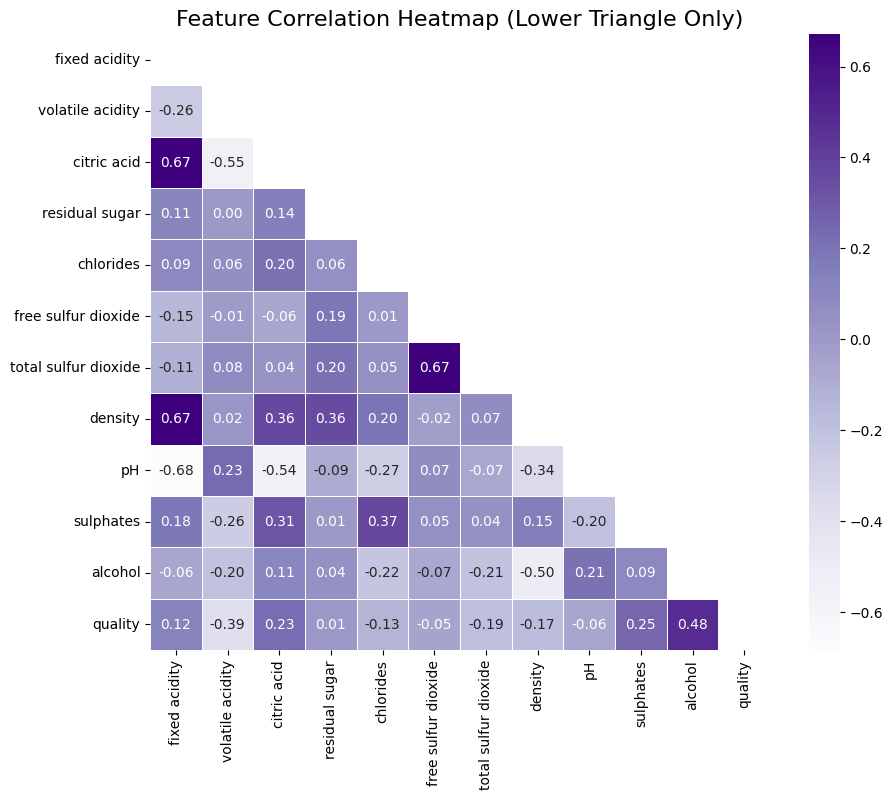

In [11]:
import numpy as np
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='Purples', fmt=".2f",
            linewidths=0.5, linecolor='white')
plt.title('Feature Correlation Heatmap (Lower Triangle Only)', fontsize=16)
plt.show()


# *2. Outlier Detection & Removal*

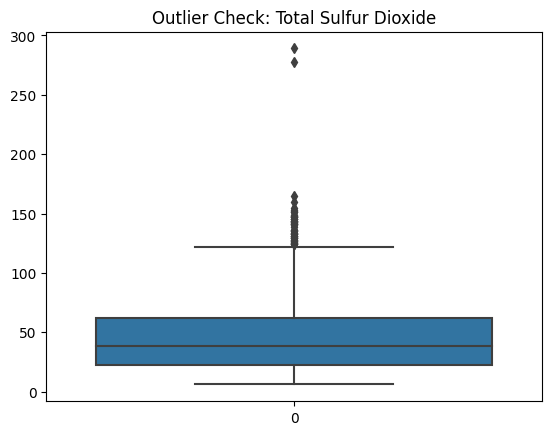

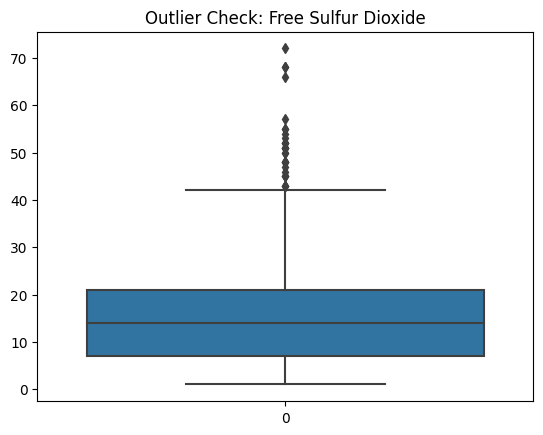

In [12]:
sns.boxplot(data=df['total sulfur dioxide'])
plt.title("Outlier Check: Total Sulfur Dioxide")
plt.show()

sns.boxplot(data=df['free sulfur dioxide'])
plt.title("Outlier Check: Free Sulfur Dioxide")
plt.show()

In [13]:
# Removing outliers using IQR

for col in ['total sulfur dioxide', 'free sulfur dioxide']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3+1.5*IQR)]

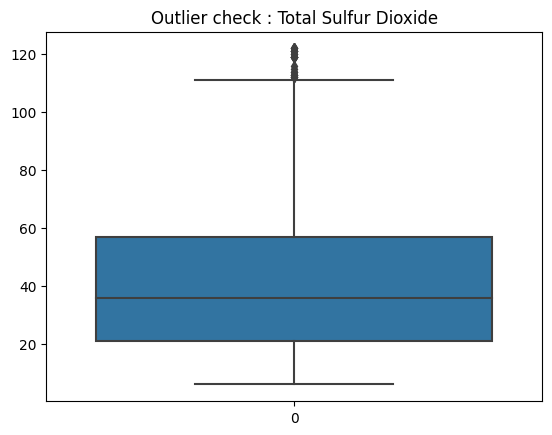

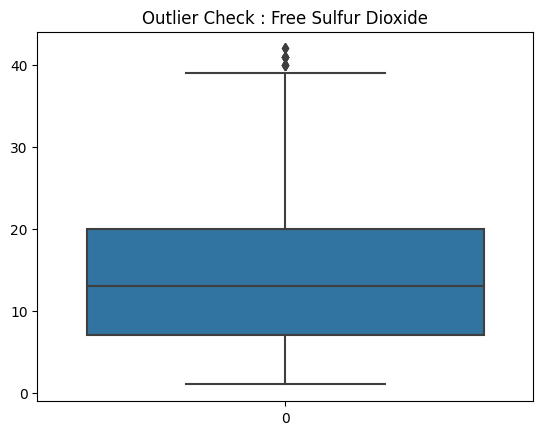

In [14]:
sns.boxplot(data=df['total sulfur dioxide'])
plt.title("Outlier check : Total Sulfur Dioxide")
plt.show()

sns.boxplot(data=df['free sulfur dioxide'])
plt.title("Outlier Check : Free Sulfur Dioxide")
plt.show()

# *3. Feature importance (via Linear Regression)*

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
X = df[['citric acid', 'density', 'fixed acidity', 'total sulfur dioxide', 'free sulfur dioxide']]
y = df['quality']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)


rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


print("Linear Regression:")
print("  MSE:", mean_squared_error(y_test, y_pred_lr))
print("  R²:", r2_score(y_test, y_pred_lr))

print("\nRandom Forest Regression:")
print("  MSE:", mean_squared_error(y_test, y_pred_rf))
print("  R²:", r2_score(y_test, y_pred_rf))

Linear Regression:
  MSE: 0.5549259219261784
  R²: 0.15512301330306466

Random Forest Regression:
  MSE: 0.4280295081967213
  R²: 0.3483233224222585


In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = df[['citric acid', 'density', 'fixed acidity', 'total sulfur dioxide', 'free sulfur dioxide']]
y = df['quality']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list = []
r2_list = []

model = RandomForestRegressor(random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_list.append(mse)
    r2_list.append(r2)

# 결과 출력
print("Cross-Validated MSE (avg):", np.mean(mse_list))
print("Cross-Validated R² (avg):", np.mean(r2_list))

Cross-Validated MSE (avg): 0.45032132592752366
Cross-Validated R² (avg): 0.31958417761758906


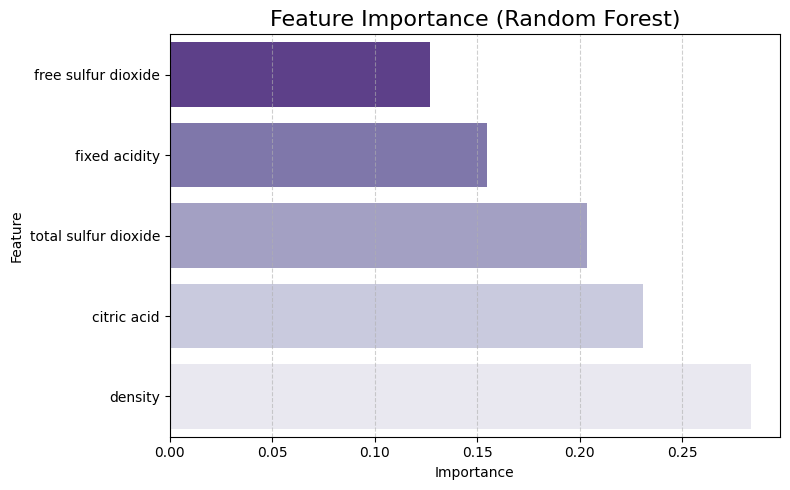

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 특성 중요도 추출
importances = rf_model.feature_importances_
feature_names = X.columns  # 입력 변수 이름들

# 시리즈로 묶고 정렬
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette='Purples_r')
plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

In [19]:
pip install xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import numpy as np

# 데이터 준비
X = df[['citric acid', 'density', 'fixed acidity', 'total sulfur dioxide', 'free sulfur dioxide']]
y = df['quality']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

# 반복 학습 및 평가
for name, model in models.items():
    mse_list = []
    r2_list = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

    print(f"{name} Results:")
    print(f"  Avg MSE: {np.mean(mse_list):.4f}")
    print(f"  Avg R²: {np.mean(r2_list):.4f}")
    print("-" * 30)



XGBoost Results:
  Avg MSE: 0.4982
  Avg R²: 0.2467
------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 1216, number of used features: 5
[LightGBM] [Info] Start training from score 5.655428
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 1217, number of used features: 5
[LightGBM] [Info] Start training from score 5.651602
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines